In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
from IPython.display import Image, display
from scipy.optimize import minimize

file_etfs = '../data_in/ETFs.csv'

# Three Asset Example (With No Correlation)

,Bond,Commodity,Equity
Bond,1.00,0.08,-0.10
Commodity,0.08,1.00,0.07
Equity,-0.10,0.07,1.00


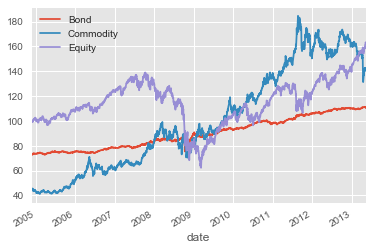

In [5]:
cols = ["date","AGG","GLD","SPY"]
# cols = ["dts","AGG","SPY"]
df = pd.read_csv(file_etfs,usecols= cols, index_col='date').rename(columns={"AGG":"Bond","GLD":"Commodity","SPY":"Equity"})
df.set_index(pd.to_datetime(df.index,format="%Y%m%d"), inplace=True)
df = df.dropna(0)
pt_ret = df.pct_change()
df.plot(figsize=(6,4))
np.round(pt_ret.corr(),2)

# Simple Risk Parity

Text(0,0.5,'Cumulative Returns')

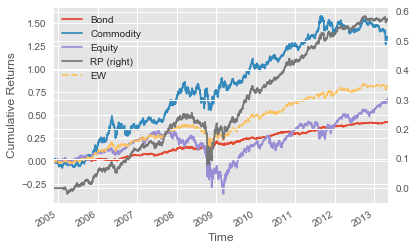

In [6]:
# Simple risk parity treats if there is no correlation among assets, thus 
# the weight is inversely proportional to recent asset volatility
# halflife used to compute asset volatility

#df_ret = pt_ret.head().unstack().reset_index().rename(columns={"level_0":"asset_id",0:"ret"})

df_std = pt_ret.rolling(window =60).std()*np.sqrt(252)
wts = (1/df_std).apply(lambda x: x/((1/df_std).sum(axis=1)))
df_ret_rp = (pt_ret * wts.shift(1)).sum(axis=1)
df_ret_static = pt_ret.dot(np.array([1/3, 1/3, 1/3]))

ax = pt_ret.cumsum().plot()
df_ret_rp.cumsum().to_frame("RP").plot(ax =ax, secondary_y= True)
(df_ret_static).to_frame("EW").cumsum().plot(ax=ax, style=['--'])

ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")

Text(0,0.5,'Risk Contribution')

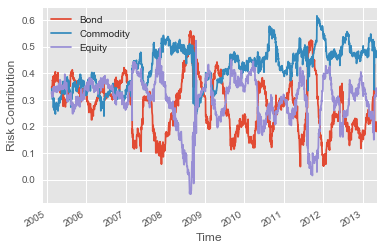

In [7]:
pt_risk_contribution = wts * 0
weighting_scheme = "NRP"
# weighting_scheme = "60-40"
lookback = 60
for i in np.arange(len(wts)):
    if i >= lookback:
        if weighting_scheme == "NRP":
            wts_vec = wts.iloc[i]
        elif weighting_scheme == "60-40":
            wts_vec = np.array([0.6,0.4])
            
        Sigma = pt_ret.iloc[i-lookback+1:i,:].cov()
        var_p = wts_vec.dot(Sigma).dot(wts_vec)
        risk_contribution_vec = (wts_vec * (Sigma.dot(wts_vec)))/var_p
        pt_risk_contribution.iloc[i,:] = np.array(risk_contribution_vec)

ax = pt_risk_contribution.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Risk Contribution")
#ax.set_title("Risk Contribution (Weighting Scheme: " + weighting_scheme + ")")

Sharpe ratio of each individual asset


Bond         0.908368
Commodity    0.761536
Equity       0.375226
dtype: float64

Sharpe ratio of equally weighted portfolio


0.9205674424959034

Sharpe ratio of Risk Parity portfolio 


1.0755351708450678

Bond         0.677009
Commodity    0.151144
Equity       0.171847
dtype: float64

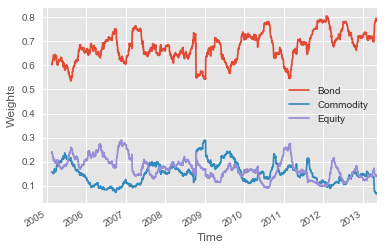

In [8]:
print("Sharpe ratio of each individual asset")
display(pt_ret.mean()/pt_ret.std()*np.sqrt(252))

print("Sharpe ratio of equally weighted portfolio")
display(df_ret_static.mean()/df_ret_static.std()*np.sqrt(252))

print("Sharpe ratio of Risk Parity portfolio ")
display(df_ret_rp.mean()/df_ret_rp.std()*np.sqrt(252))

ax = wts.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Weights")
#On average 67% is allocated to bonds, 16% to gold and 18% to equities
wts.mean()



# Multiple Asset RP containing highly correlated assets 

,AGG,EEM,GLD,IWM,QQQ,SPY,TLT
AGG,1.00,-0.12,0.08,-0.18,-0.13,-0.10,0.54
EEM,-0.12,1.00,0.19,0.82,0.84,0.89,-0.40
GLD,0.08,0.19,1.00,0.07,0.04,0.07,0.04
IWM,-0.18,0.82,0.07,1.00,0.88,0.92,-0.44
QQQ,-0.13,0.84,0.04,0.88,1.00,0.91,-0.42
SPY,-0.10,0.89,0.07,0.92,0.91,1.00,-0.45
TLT,0.54,-0.40,0.04,-0.44,-0.42,-0.45,1.00


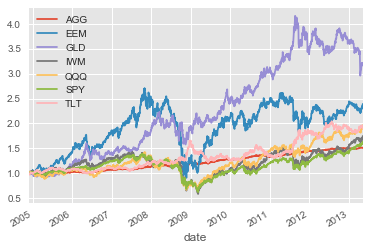

In [11]:
cols = ["date","AGG","TLT","GLD","SPY","QQQ","IWM","EEM"]
df = pd.read_csv(file_etfs,usecols= cols, index_col='date')
df.set_index(pd.to_datetime(df.index,format="%Y%m%d"),inplace=True)
df = df.dropna(0)
df_ret = df.pct_change()
display(np.round(df_ret.corr(),2))

ax = (1+df_ret).cumprod().plot()



# Real Risk Parity 

In [43]:
df_ret.mean()/df_ret.std()*np.sqrt(252)

AGG    0.908368
EEM    0.461308
GLD    0.761536
IWM    0.377264
QQQ    0.466754
SPY    0.375226
TLT    0.591543
dtype: float64

In [ ]:
ret_mat

### calculate weights (equal risk contribution) - all periods

In [63]:
wts_vec = np.array([1/df_ret.shape[1]]* df_ret.shape[1])
ret_mat = df_ret.copy()

def rp_cost_func(wts_vec, ret_mat, min_type = "mad"):
    risk_contribution_vec = calc_risk_contribution(wts_vec, ret_mat)
    if min_type == "mad":
        return sum(abs(risk_contribution_vec - 1/len(risk_contribution_vec)))
    elif  min_type == "mse":
        return (risk_contribution_vec - 1/len(risk_contribution_vec)).std()
def calc_risk_contribution(wts_vec, ret_mat):
    Sigma = ret_mat.cov()
    var_p = wts_vec.dot(Sigma).dot(wts_vec)
    risk_contribution_vec = (wts_vec * (Sigma.dot(wts_vec)))/var_p
    return risk_contribution_vec
    
    
ans = minimize(rp_cost_func, wts_vec, (ret_mat, "mse"), bounds=[(0,1)] * df_ret.shape[1])


wts_optimal = ans.x
risk_contribution_vec = calc_risk_contribution(wts_optimal, ret_mat)

print(risk_contribution_vec)

print(wts_optimal)

AGG    0.166666
EEM    0.166666
GLD    0.166666
IWM    0.166668
QQQ    0.166667
SPY    0.166667
TLT   -0.000000
dtype: float64
[0.66706389 0.04723877 0.13733708 0.06692225 0.07997217 0.07885029
 0.        ]


### calculate weights (equal risk contribution) -rolling

In [225]:
wts_vec = np.array([1/df_ret.shape[1]]* df_ret.shape[1])
asset_returns = df_ret.copy()


In [ ]:
calc_risk_contribution(wts_vec, ret_mat)[in_fi].sum()

In [333]:
asset_class_map = {"AGG":"Fixed Income", 
                   "TLT":"Fixed Income", 
                  "EEM":"Equity", 
                  "GLD":"Commodity", 
                  "IWM":"Equity",
                  "QQQ":"Equity",
                  "SPY":"Equity"}

def rp_cost_func(wts_vec, ret_mat, min_type = "min_var"):
    Sigma = ret_mat.cov()
    var_p = wts_vec.dot(Sigma).dot(wts_vec)
    risk_contribution_vec = (wts_vec * (Sigma.dot(wts_vec)))/var_p
    
    if min_type == "mad":
        return sum(abs(risk_contribution_vec - 1/len(risk_contribution_vec)))
    elif  min_type == "mse":
        return (risk_contribution_vec - 1/len(risk_contribution_vec)).std()
    elif min_type == "min_var":
        return var_p
    
# def calc_risk_contribution(wts_vec, ret_mat):
#     Sigma = ret_mat.cov()
#     var_p = wts_vec.dot(Sigma).dot(wts_vec)
#     risk_contribution_vec = (wts_vec * (Sigma.dot(wts_vec)))/var_p
#     return risk_contribution_vec

weights_optimal = asset_returns*np.nan
num_assets = asset_returns.shape[1]
wts_optimal = wts_vec
rebal_freq = 66
time_since_last_rebal = 0
lookback = 90
asset_bound_min = 0.0
asset_bound_max = 1.0

# portfolio unit weight constraint 
cons_unit_weight = {'type': 'eq', 'fun': lambda x:  x.sum()-1}

# asset_bounds 
bounds = [(asset_bound_min, asset_bound_max)] * num_assets

# asset_class_constraints
asset_classes = [asset_class_map[x] for x in asset_returns.columns.values]
in_eq = np.in1d(asset_classes, "Equity")
in_fi = np.in1d(asset_classes, "Fixed Income")
in_com = np.in1d(asset_classes, "Commodity")
risk_allocation_map = {"Fixed Income": 0.3, 
                      "Equity": 0.3, 
                      "Commodity": 0.3}

for i in range(len(asset_returns)):
    if i >= lookback:
        if time_since_last_rebal >= rebal_freq:
            ret_mat = asset_returns.iloc[i-lookback:i,:]
             
            cons_eq_eq = {'type': 'ineq', 'fun': 
                          lambda x:  calc_risk_contribution(x, ret_mat)[in_eq].sum() 
                              -risk_allocation_map["Equity"]}
            cons_eq_fi = {'type': 'ineq', 'fun': 
                          lambda x:  calc_risk_contribution(x, ret_mat)[in_fi].sum() 
                              -risk_allocation_map["Fixed Income"]}
            cons_eq_com = {'type': 'ineq', 'fun': 
                          lambda x:  calc_risk_contribution(x, ret_mat)[in_com].sum() 
                              -risk_allocation_map["Commodity"]}
            
            cons = (cons_eq_eq,
                   cons_eq_fi,
                    cons_eq_com, 
                   cons_unit_weight)
            
            ans = minimize(rp_cost_func, wts_vec, (ret_mat, "min_var"), 
                           bounds=bounds, 
                          constraints=cons, 
                          tol  = 1e-9)
            wts_optimal = ans.x
            time_since_last_rebal = 0
            
            print("%4.2f%% completed" %(i/len(asset_returns)*100))
        time_since_last_rebal += 1
        weights_optimal.iloc[i,:] = wts_optimal
        
        

7.32% completed
10.41% completed
13.51% completed
16.60% completed
19.70% completed
22.80% completed
25.89% completed
28.99% completed
32.08% completed
35.18% completed
38.27% completed
41.37% completed
44.47% completed
47.56% completed
50.66% completed
53.75% completed
56.85% completed
59.94% completed
63.04% completed
66.14% completed
69.23% completed
72.33% completed
75.42% completed
78.52% completed
81.61% completed
84.71% completed
87.80% completed
90.90% completed
94.00% completed
97.09% completed


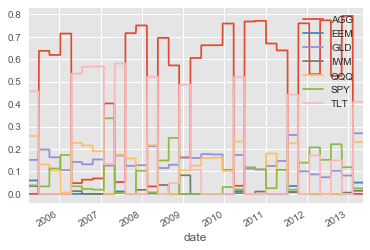

In [334]:
weights_optimal.iloc[lookback:].dropna().plot()

In [335]:
risk_contribution_vec = calc_risk_contribution(weights_optimal.iloc[lookback:].dropna().mean(), asset_returns)


df_risk_contribution = risk_contribution_vec.to_frame("risk_contribution")\
    .join(weights_optimal.dropna().mean().to_frame("optimal_weights"))\
    .reset_index().rename(columns={"index":"asset_id"})
df_risk_contribution["asset_class"] = df_risk_contribution["asset_id"].replace(asset_class_map)


In [336]:
df_risk_contribution.groupby("asset_class").sum()

,risk_contribution,optimal_weights
asset_class,,
Commodity,0.266284,0.144401
Equity,0.349277,0.203066
Fixed Income,0.384439,0.652532


Text(0,0.5,'Risk Contribution')

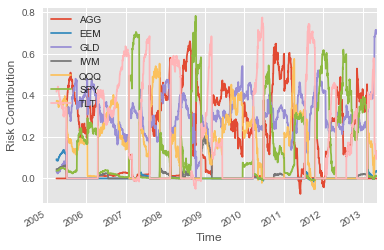

In [337]:
pt_risk_contribution = weights_optimal * 0
weighting_scheme = "NRP"
# weighting_scheme = "60-40"
lookback = 60
for i in np.arange(len(weights_optimal)):
    if i >= lookback:
        if weighting_scheme == "NRP":
            wts_vec = weights_optimal.iloc[i]
        elif weighting_scheme == "60-40":
            wts_vec = np.array([0.6,0.4])
            
        Sigma = asset_returns.iloc[i-lookback+1:i,:].cov()
        var_p = wts_vec.dot(Sigma).dot(wts_vec)
        risk_contribution_vec = (wts_vec * (Sigma.dot(wts_vec)))/var_p
        pt_risk_contribution.iloc[i,:] = np.array(risk_contribution_vec)

ax = pt_risk_contribution.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Risk Contribution")


In [338]:
risk_con_by_asset_class = pt_risk_contribution.dropna().loc[:,in_com].sum(axis=1).to_frame("com")\
    .join(pt_risk_contribution.dropna().loc[:,in_fi].sum(axis=1).to_frame("fi"))\
    .join(pt_risk_contribution.dropna().loc[:,in_eq].sum(axis=1).to_frame("eq"))

risk_con_by_asset_class.mean()

com    0.302700
fi     0.385419
eq     0.311881
dtype: float64

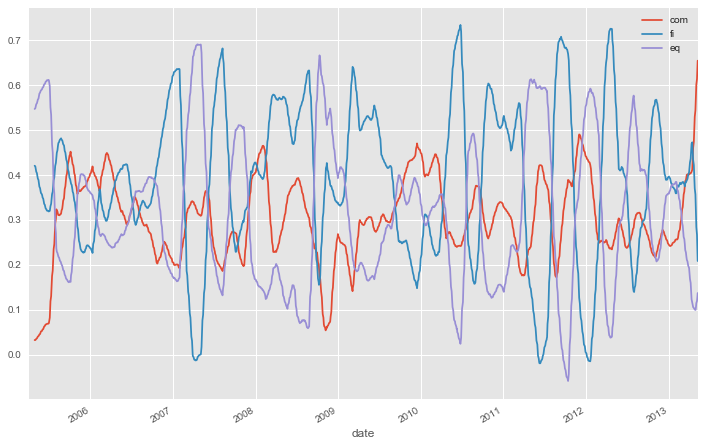

In [339]:
risk_con_by_asset_class.rolling(window=22).mean().plot(figsize=(12,8))

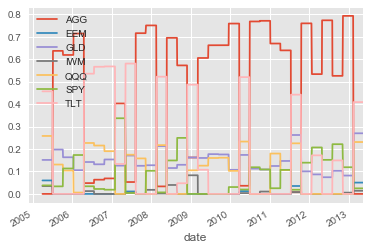

In [341]:
weights_optimal.plot()

In [ ]:
pt_risk_contribution.dropna()[["spy"]].sum(axis=1).plot(figsize=(12,8))

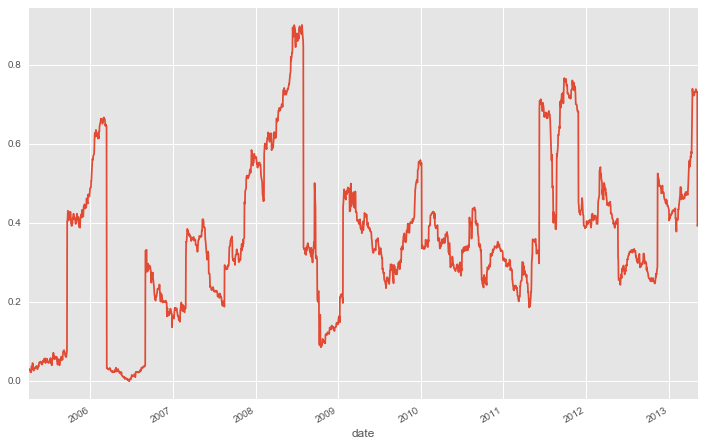

In [292]:
pt_risk_contribution.dropna()[["GLD"]].sum(axis=1).plot(figsize=(12,8))

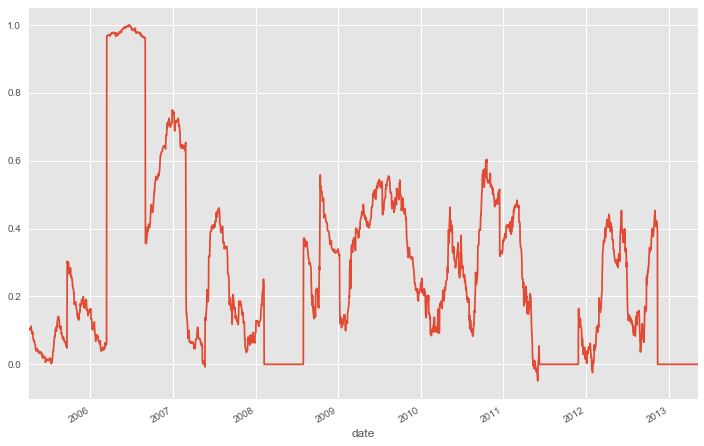

In [291]:
pt_risk_contribution.dropna()[["AGG", "TLT"]].sum(axis=1).plot(figsize=(12,8))

### calculate weights (equal inverse vol) -rolling

In [113]:
weights_optimal_naive = asset_returns*0
num_assets = asset_returns.shape[1]
wts_optimal = wts_vec
lookback = 252*2

weights_optimal_naive = 1/asset_returns.rolling(window= lookback).std()
weights_optimal_naive = weights_optimal_naive.apply(lambda x: x/x.sum(), axis=1) 

In [120]:
risk_contribution_vec = calc_risk_contribution(weights_optimal_naive.median(), asset_returns)


risk_contribution_vec.to_frame("risk_contribution")\
    .join(weights_optimal_naive.mean().to_frame("optimal_weights"))
    

,risk_contribution,optimal_weights
AGG,0.091655,0.418665
EEM,0.203614,0.059040
GLD,0.096857,0.099624
IWM,0.199037,0.076100
QQQ,0.195978,0.092777
SPY,0.204763,0.102065
TLT,0.008096,0.151729


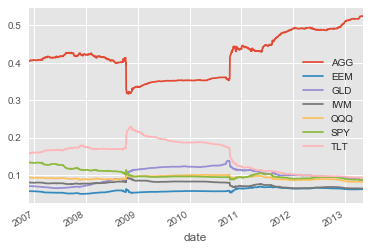

In [117]:
weights_optimal_naive.dropna().plot()

0.9026458846203438
8.956472790205991


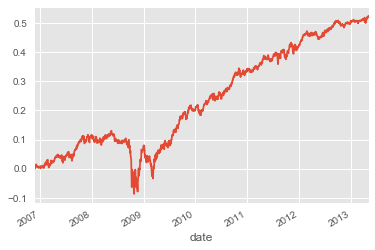

In [279]:
eq_curve_naive = (weights_optimal_naive.shift(1) * asset_returns).dropna().sum(axis=1)
eq_curve_naive.cumsum().plot()

print(eq_curve_naive.mean()/eq_curve_naive.std()*np.sqrt(252))
print(eq_curve_naive.std()*np.sqrt(252)*100)

In [ ]:
(weights_optimal.shift(1) * asset_returns).iloc[lookback:].dropna()

1.2422951115036698
7.461116998670553


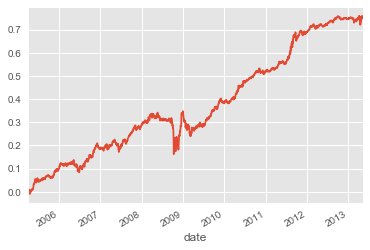

In [342]:
eq_curve_rp = (weights_optimal.shift(1) * asset_returns).iloc[lookback:].dropna().sum(axis=1)
eq_curve_rp.cumsum().plot()

print(eq_curve_rp.mean()/eq_curve_rp.std()*np.sqrt(252))
print(eq_curve_rp.std()*np.sqrt(252)*100)